# Partitioning VS Bucketing
- partition: if we have a table with a  column with most  frequently occurring entries or less uniques entries

- bucketing: if we have a table where we do not have such column or every column has mostly uniques values

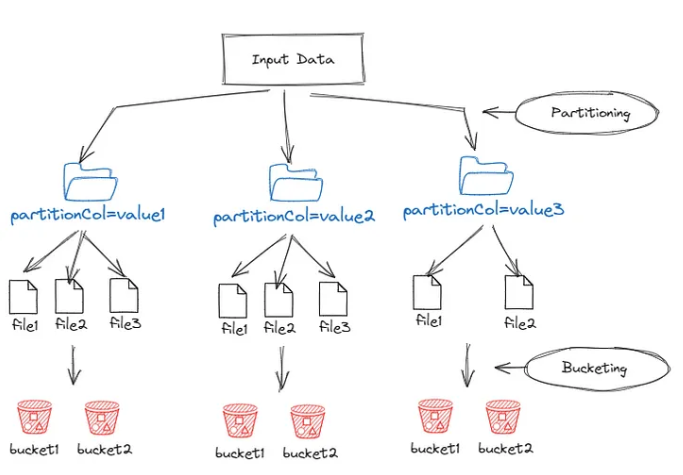

# Partitioning
**Parallelism:** By dividing data into partitions, Spark can distribute these partitions across multiple nodes in a cluster. This enables parallel processing, significantly improving the performance of data operations.

**Efficient Data Processing:** Smaller partitions are easier to manage and manipulate. When a specific operation is performed on a partition, it affects a smaller subset of the data, reducing memory overhead.

**Data Locality:** Spark aims to process data where it resides. By creating partitions that align with the distribution of data across nodes, Spark can optimize data locality, minimizing data transfer over the network.

# How to Control Partitioning
Spark uses 2 types of partitioning:

**1. Partitioning in memory**
- While transfrorming data Spark allows users to control partitioning explicitly by using repartition or coalesce.

1.1 Repartition
- increase / decrease (better use coalesce for decreasing) the number of partitions.
- data needs to be evenly distributed across the cluster
- Full Shuffle
- specify the desired number of partitions and the column(s) to partition by.
- shuffles the data to create the specified number of partitions.


```
df = df.repartition(4, "department")
```



1.2 Coalesce
- without a full shuffle
- reduces the number of partitions by merging them.
- to decrease the number of partitions for efficiency.
By default, Spark/PySpark creates partitions that are equal to the number of CPU cores in the machine.


```
df.coalesce(2)
```

**2. Partitioning on disk**
- When writing data in Spark, the partitionBy() method is used to partition the data into a file system, resulting in multiple sub-directories. This partitioning enhances the read performance for downstream systems.

*Type of Partitionung in Saprk:*
- hash partitioning
  - distributes data based on a hash function, ensuring equal distribution.
- range partitioning
  - involves organizing data within specific ranges.
- custom partitioning
  - allows users to define their partitioning logic, offering flexibility.

```
df.write.mode("overwrite").partitionBy("sex").parquet("data/output")
```

*Factors affecting partitioning*

*   Business logic
  *   reduce the amount of data the Spark cluster needs to process.
*   Data
*   Environment

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "partitioning vs bucketing") \
    .getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hash Partitioning
- default partitioning method in PySpark.
- using a hash function to determine the partition for each data item. Th
- evenly distributes data across partitions based on the hash value of a specific column.

In [9]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("hash_partitioning_example").getOrCreate()

# Create a sample DataFrame
data = spark.createDataFrame([

    (101, "John", 28),

    (102, "Jane", 34),

    (103, "Jake", 45),

    (104, "Jill", 29),

    (105, "Jack", 37),

    (106, "Jenny", 42)

], ["employee_id", "employee_name", "employee_age"])


# Perform hash partitioning on the DataFrame based on the "employee_id" column
partitioned_data = data.repartition(4, "employee_id")

# Print the DataFrame
data.show()

# Print the elements in each partition
print(partitioned_data.rdd.glom().collect())

+-----------+-------------+------------+
|employee_id|employee_name|employee_age|
+-----------+-------------+------------+
|        101|         John|          28|
|        102|         Jane|          34|
|        103|         Jake|          45|
|        104|         Jill|          29|
|        105|         Jack|          37|
|        106|        Jenny|          42|
+-----------+-------------+------------+

[[], [Row(employee_id=101, employee_name='John', employee_age=28), Row(employee_id=102, employee_name='Jane', employee_age=34)], [Row(employee_id=104, employee_name='Jill', employee_age=29)], [Row(employee_id=103, employee_name='Jake', employee_age=45), Row(employee_id=105, employee_name='Jack', employee_age=37), Row(employee_id=106, employee_name='Jenny', employee_age=42)]]


# Range Partitioning
- divides data into partitions based on specified ranges of column values.
- Each partition contains data within a particular range, making it efficient for range-based queries.

In [10]:
# Import required modules
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("hash_partitioning_example").getOrCreate()

# Create a sample DataFrame
data = spark.createDataFrame([

    (101, "John", 28),

    (102, "Jane", 34),

    (103, "Jake", 45),

    (104, "Jill", 29),

    (105, "Jack", 37),

    (106, "Jenny", 42)

], ["employee_id", "employee_name", "employee_age"])


# Perform range partitioning on the DataFrame based on the "employee_id" column
partitioned_data = data.repartitionByRange(3, "employee_age")

# Print the DataFrame
data.show()

# Print the elements in each partition
print(partitioned_data.rdd.glom().collect())

+-----------+-------------+------------+
|employee_id|employee_name|employee_age|
+-----------+-------------+------------+
|        101|         John|          28|
|        102|         Jane|          34|
|        103|         Jake|          45|
|        104|         Jill|          29|
|        105|         Jack|          37|
|        106|        Jenny|          42|
+-----------+-------------+------------+

[[Row(employee_id=101, employee_name='John', employee_age=28), Row(employee_id=104, employee_name='Jill', employee_age=29)], [Row(employee_id=102, employee_name='Jane', employee_age=34), Row(employee_id=105, employee_name='Jack', employee_age=37)], [Row(employee_id=103, employee_name='Jake', employee_age=45), Row(employee_id=106, employee_name='Jenny', employee_age=42)]]


# Custom Partitioning

In [18]:
def customPartitioning(key):
  if key >= 0 and key <= 10:
    return 1
  elif key >= 11 and key <= 20:
    return 2
  else:
    return 3

df = spark.range(50)
num_partition = 5

partition_rdd = df.rdd.map(lambda row: (row["id"], row)).partitionBy(num_partition, customPartitioning)
results = partition_rdd.glom().collect()
print(results)

for index, partition in enumerate(results):
  print(f"")

[[], [(0, Row(id=0)), (1, Row(id=1)), (2, Row(id=2)), (3, Row(id=3)), (4, Row(id=4)), (5, Row(id=5)), (6, Row(id=6)), (7, Row(id=7)), (8, Row(id=8)), (9, Row(id=9)), (10, Row(id=10))], [(11, Row(id=11)), (12, Row(id=12)), (13, Row(id=13)), (14, Row(id=14)), (15, Row(id=15)), (16, Row(id=16)), (17, Row(id=17)), (18, Row(id=18)), (19, Row(id=19)), (20, Row(id=20))], [(21, Row(id=21)), (22, Row(id=22)), (23, Row(id=23)), (24, Row(id=24)), (25, Row(id=25)), (26, Row(id=26)), (27, Row(id=27)), (28, Row(id=28)), (29, Row(id=29)), (30, Row(id=30)), (31, Row(id=31)), (32, Row(id=32)), (33, Row(id=33)), (34, Row(id=34)), (35, Row(id=35)), (36, Row(id=36)), (37, Row(id=37)), (38, Row(id=38)), (39, Row(id=39)), (40, Row(id=40)), (41, Row(id=41)), (42, Row(id=42)), (43, Row(id=43)), (44, Row(id=44)), (45, Row(id=45)), (46, Row(id=46)), (47, Row(id=47)), (48, Row(id=48)), (49, Row(id=49))], []]


# Shuffling Issue

In [7]:
users = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/FOO JIA ERN/2025 Goals & Plans/Spark/data/input/emp.csv")
users.show()

users_joined_table = spark.read.format("csv").option("header", True).option("inferSchema", True).load("/content/drive/MyDrive/FOO JIA ERN/2025 Goals & Plans/Spark/data/input/emp.csv")

+-----------+-------------+-------------+---+------+------+----------+
|employee_id|department_id|         name|age|gender|salary| hire_date|
+-----------+-------------+-------------+---+------+------+----------+
|          1|          101|     John Doe| 30|  Male| 50000|2015-01-01|
|          2|          101|   Jane Smith| 25|Female| 45000|2016-02-15|
|          3|          102|    Bob Brown| 35|  Male| 55000|2014-05-01|
|          4|          102|    Alice Lee| 28|Female| 48000|2017-09-30|
|          5|          103|    Jack Chan| 40|  Male| 60000|2013-04-01|
|          6|          103|    Jill Wong| 32|Female| 52000|2018-07-01|
|          7|          101|James Johnson| 42|  Male| 70000|2012-03-15|
|          8|          102|     Kate Kim| 29|Female| 51000|2019-10-01|
|          9|          103|      Tom Tan| 33|  Male| 58000|2016-06-01|
|         10|          104|     Lisa Lee| 27|Female| 47000|2018-08-01|
|         11|          104|   David Park| 38|  Male| 65000|2015-11-01|
|     

#Method 1: Avoid Shuffling by repartionining & caching first

In [8]:
users = users.repartition('department_id').cache() # do not forget to cache!
joined1 = users.join(users_joined_table, 'department_id')
joined1.show() # 1st shuffle for repartition
joined2 = users.join(users_joined_table, 'department_id')
joined2.show() # skips shuffle for users since it's already been repartitioned

+-------------+-----------+-------------+---+------+------+----------+-----------+-------------+---+------+------+----------+
|department_id|employee_id|         name|age|gender|salary| hire_date|employee_id|         name|age|gender|salary| hire_date|
+-------------+-----------+-------------+---+------+------+----------+-----------+-------------+---+------+------+----------+
|          101|          1|     John Doe| 30|  Male| 50000|2015-01-01|          7|James Johnson| 42|  Male| 70000|2012-03-15|
|          101|          1|     John Doe| 30|  Male| 50000|2015-01-01|          2|   Jane Smith| 25|Female| 45000|2016-02-15|
|          101|          1|     John Doe| 30|  Male| 50000|2015-01-01|          1|     John Doe| 30|  Male| 50000|2015-01-01|
|          101|          2|   Jane Smith| 25|Female| 45000|2016-02-15|          7|James Johnson| 42|  Male| 70000|2012-03-15|
|          101|          2|   Jane Smith| 25|Female| 45000|2016-02-15|          2|   Jane Smith| 25|Female| 45000|2016

#Method 2: Avoid Shuffling using bucketing

In [4]:
t1 = spark.table('unbucketed1')
t2 = spark.table('unbucketed2')

t1.join(t2, 'key').explain()

# == Physical Plan ==
# *(5) Project [key#10L, value#11, value#15]
# +- *(5) SortMergeJoin [key#10L], [key#14L], Inner
#    :- *(2) Sort [key#10L ASC NULLS FIRST], false, 0
#    :  +- Exchange hashpartitioning(key#10L, 200)
#    :     +- *(1) Project [key#10L, value#11]
#    :        +- *(1) Filter isnotnull(key#10L)
#    :           +- *(1) FileScan parquet default.unbucketed1[key#10L,value#11] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/opt/spark/spark-warehouse/unbucketed1], PartitionFilters: [], PushedFilters: [IsNotNull(key)], ReadSchema: struct<key:bigint,value:double>
#    +- *(4) Sort [key#14L ASC NULLS FIRST], false, 0
#       +- Exchange hashpartitioning(key#14L, 200)
#          +- *(3) Project [key#14L, value#15]
#             +- *(3) Filter isnotnull(key#14L)
#                +- *(3) FileScan parquet default.unbucketed2[key#14L,value#15] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/opt/spark/spark-warehouse/unbucketed2], PartitionFilters: [], PushedFilters: [IsNotNull(key)], ReadSchema: struct<key:bigint,value:double>, SelectedBucketsCount: 16 out of 16

# SortMergeJoin: default Spark join
# 2 Exchange operations: shuffle our data (should avoid)

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `unbucketed1` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.;
'UnresolvedRelation [unbucketed1], [], false


# Spark Bucketing
- a technique used in Spark for optimizing data storage & querying performance, especially when dealing with large datasets. It involves dividing data into a fixed number of buckets and storing each bucket as a separate file.

**Why Bucket Data?**
- Bucketing provides several advantages:

**Efficient Data Retrieval:**
- When querying data, Spark can narrow down the search by reading only specific buckets, reducing the amount of data to scan. This results in faster query performance.

**Uniform Bucket Sizes:**
- Bucketing ensures that each bucket contains approximately the same number of records, preventing data skew.

In [ ]:
df.write\
    .bucketBy(16, 'key') \
    .sortBy('value') \
    .saveAsTable('bucketed', format='parquet')

In [ ]:
t2 = spark.table('bucketed')
t3 = spark.table('bucketed')

# bucketed - bucketed join.
# Both sides have the same bucketing, and no shuffles are needed.
t3.join(t2, 'key').explain()

# == Physical Plan ==
# *(3) Project [key#14L, value#15, value#30]
# +- *(3) SortMergeJoin [key#14L], [key#29L], Inner
#    :- *(1) Sort [key#14L ASC NULLS FIRST], false, 0
#    :  +- *(1) Project [key#14L, value#15]
#    :     +- *(1) Filter isnotnull(key#14L)
#    :        +- *(1) FileScan parquet default.bucketed[key#14L,value#15] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/opt/spark/spark-warehouse/bucketed], PartitionFilters: [], PushedFilters: [IsNotNull(key)], ReadSchema: struct<key:bigint,value:double>, SelectedBucketsCount: 16 out of 16
#    +- *(2) Sort [key#29L ASC NULLS FIRST], false, 0
#       +- *(2) Project [key#29L, value#30]
#          +- *(2) Filter isnotnull(key#29L)
#             +- *(2) FileScan parquet default.bucketed[key#29L,value#30] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/opt/spark-warehouse/bucketed], PartitionFilters: [], PushedFilters: [IsNotNull(key)], ReadSchema: struct<key:bigint,value:double>, SelectedBucketsCount: 16 out of 16

In [ ]:
# DESCRIBE EXTENDED¶
# Use SessionCatalog or DESCRIBE EXTENDED SQL command to find the bucketing information.

describeSQL = spark.sql("DESCRIBE EXTENDED $demoTable")